<a href="https://colab.research.google.com/github/ShawnSchmucker/MAE-494-Fall-2022/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Formulation**

The objective function is the state $s(t) = [d(t), v(t), \theta(t), \omega(t)]^T$, where $d(t)$ is the distance of the rocket from the ground, $v(t)$ is its velocity, $\theta(t)$ is its angle from the vertical, and $\omega(t)$ is its angular velocity.

The control inputs are the rocket's vertical acceleration $a(t)$, and its angular acceleration $\alpha(t)$.

The dynamics are:

$\quad d(t+1) = d(t) + v(t) \Delta t$,

$\quad v(t+1) = v(t) + a(t) \Delta t$,

$\quad \theta(t+1) = \theta(t) + \omega(t) \Delta t$,

$\quad \omega(t+1) = \omega(t) + \alpha(t) \Delta t$,

where $\Delta t$ is the time step.

The controller is $c(t) = [a(t), \alpha(t)]^T = f_\theta(s(t))$, where $f_\theta$ is a neural network with optimized parameters $\theta$.

The loss is 0 for all time $t = 1,...,T-1$, where $T$ is the final time step. At $t = T,$ the loss $l(s(T), c(T)) = ||s(T)||^2 = d(T)^2 + v(T)^2 + \theta(T)^2 + \omega(T)^2$.

The optimization problem is:

$\quad \min \limits_{\theta} \quad ||s(T)||^2$

$\qquad \qquad d(t+1) = d(t) + v(t) \Delta t$,

$\qquad \qquad v(t+1) = v(t) + a(t) \Delta t$,

$\qquad \qquad \theta(t+1) = \theta(t) + \omega(t) \Delta t$,

$\qquad \qquad \omega(t+1) = \omega(t) + \alpha(t) \Delta t$,

$\qquad \qquad c(t) = [a(t), \alpha(t)]^T = f_\theta(s(t)), \, \forall t = 1,...,T-1$.

This formulation assumes...

[1] loss: 87439.211


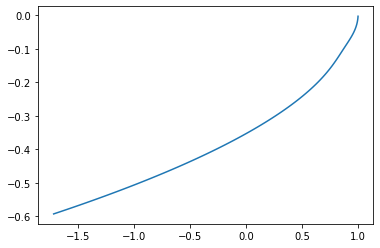

[2] loss: 87439.211


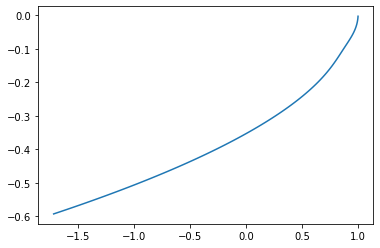

[3] loss: 87439.211


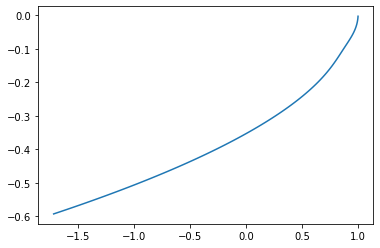

[4] loss: 87439.211


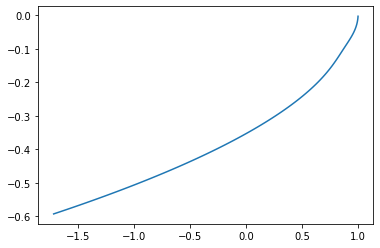

[5] loss: 87439.211


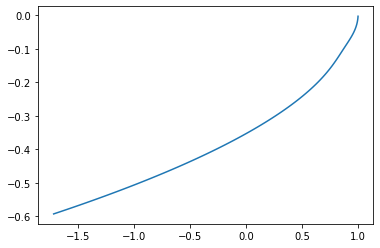

[6] loss: 87439.211


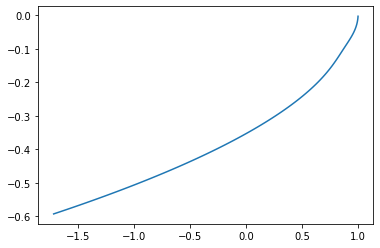

[7] loss: 87439.211


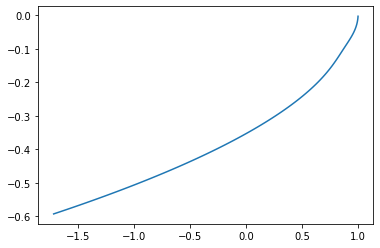

[8] loss: 87439.211


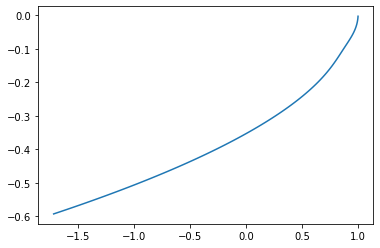

[9] loss: 87439.211


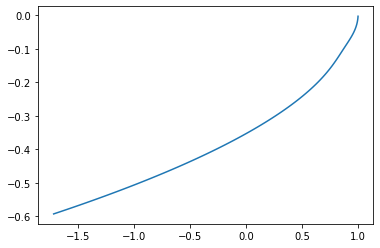

[10] loss: 87439.211


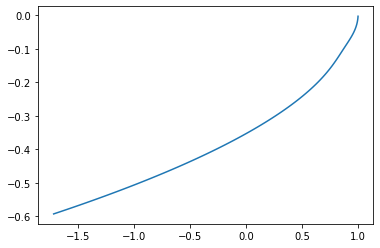

[11] loss: 87439.211


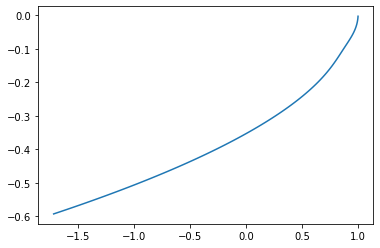

[12] loss: 87439.211


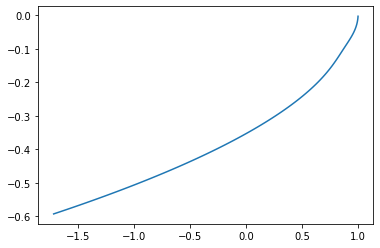

[13] loss: 87439.211


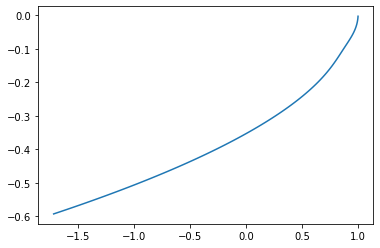

[14] loss: 87439.211


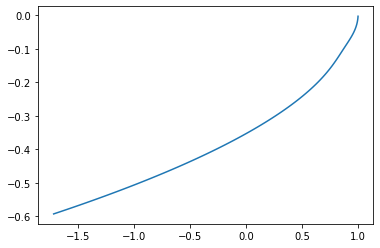

[15] loss: 87439.211


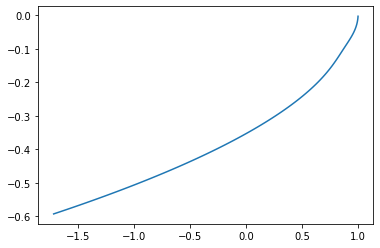

[16] loss: 87439.211


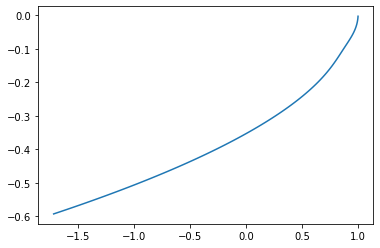

[17] loss: 87439.211


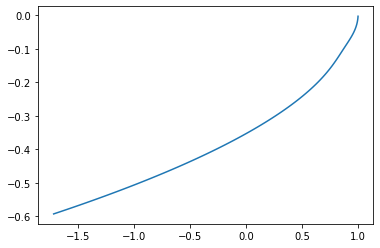

[18] loss: 87439.211


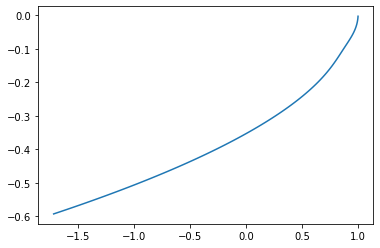

[19] loss: 87439.211


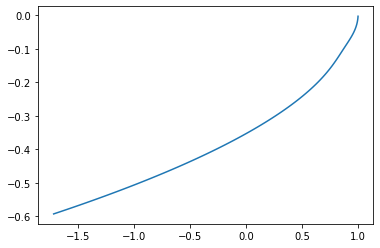

[20] loss: 87439.211


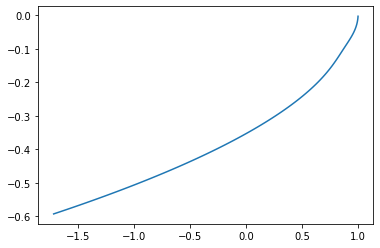

[21] loss: 87439.211


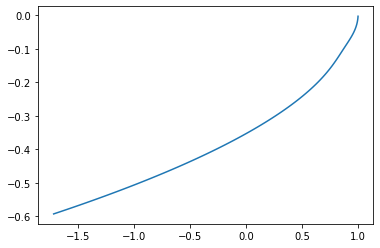

[22] loss: 87439.211


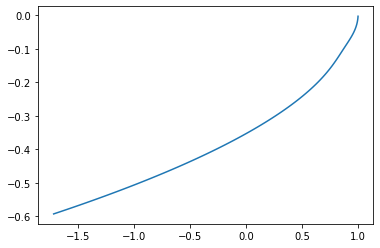

[23] loss: 87439.211


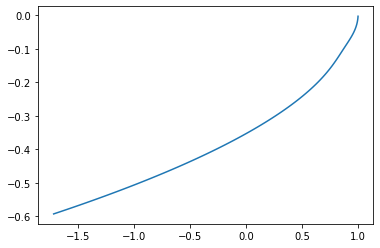

[24] loss: 87439.211


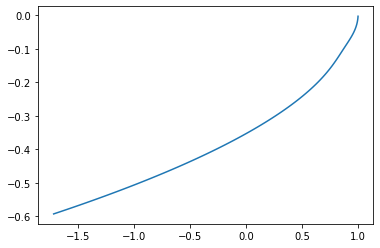

[25] loss: 87439.211


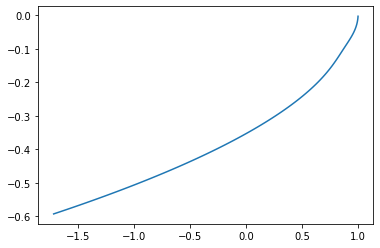

[26] loss: 87439.211


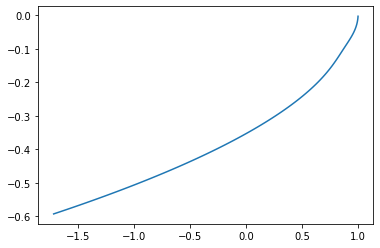

[27] loss: 87439.211


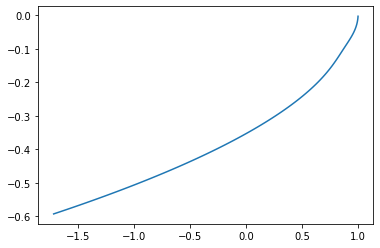

[28] loss: 87439.211


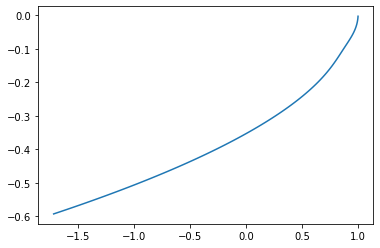

[29] loss: 87439.211


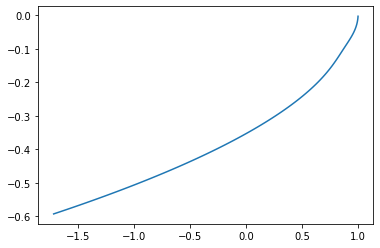

[30] loss: 87439.211


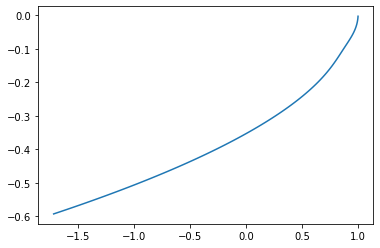

[31] loss: 87439.211


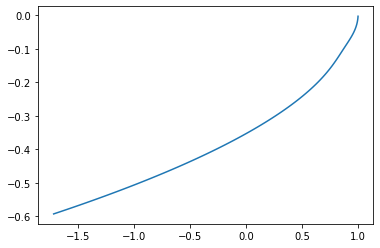

[32] loss: 87439.211


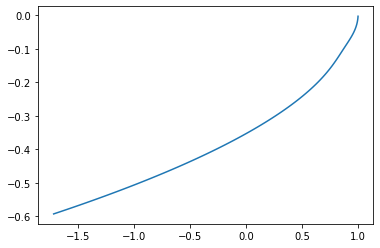

[33] loss: 87439.211


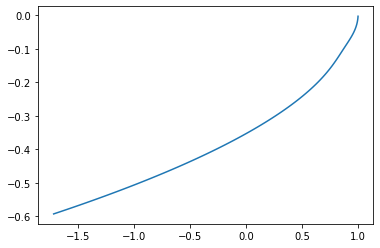

[34] loss: 87439.211


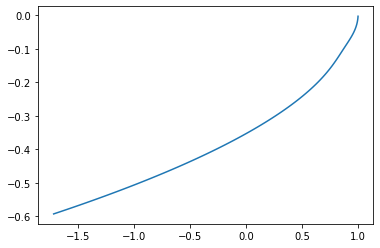

[35] loss: 87439.211


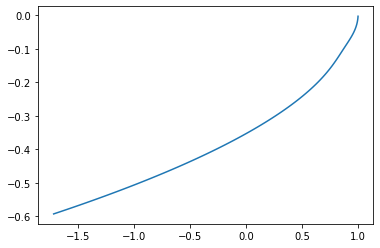

[36] loss: 87439.211


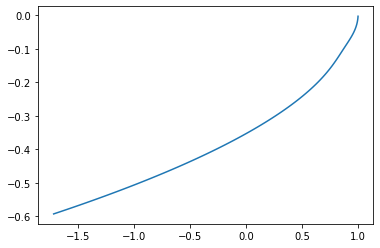

[37] loss: 87439.211


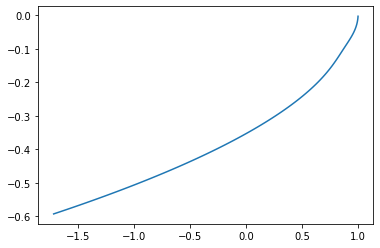

[38] loss: 87439.211


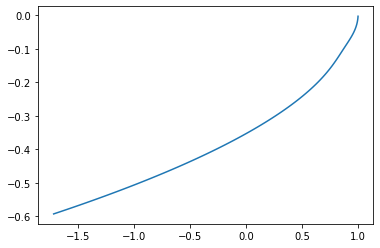

[39] loss: 87439.211


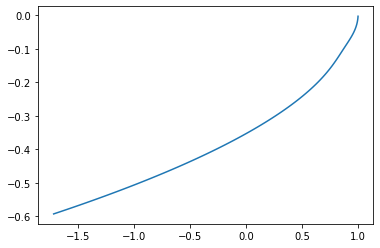

[40] loss: 87439.211


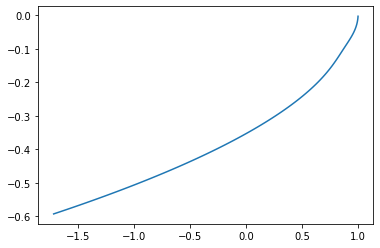

In [11]:
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

DT = 0.1 # time step
G = 0.12 # gravitational acceleration constant
THRUST = 0.18 # linear thrust constant
ROTATE = 20 # rotational thrust constant

class Dynamics(nn.Module):

  def __init__(self):
    super(Dynamics, self).__init__()
  
  @staticmethod
  def forward(state, action):

    dx_gravity = t.tensor([0., -G * DT, 0., 0.])

    dx_thrust = t.tensor([0., THRUST * DT * action[0], 0., ROTATE * DT * action[1]])

    state = state + dx_gravity + dx_thrust
    
    step_mat = t.tensor([[1., DT, 0., 0.],
                        [0., 1., 0., 0.],
                        [0., 0., 1., DT],
                        [0., 0., 0., 1.]])
    
    state = t.matmul(step_mat, state.T)

    return state

class Controller(nn.Module):

  def __init__(self, dim_input, dim_hidden, dim_output):

    super(Controller, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(dim_input, dim_hidden),
        nn.Tanh(),
        nn.Linear(dim_hidden, dim_output),
        nn.Sigmoid()
    )
  
  def forward(self, state):
    action = self.network(state)
    return action

class Simulation(nn.Module):

  def __init__(self, controller, dynamics, T):
    super(Simulation, self).__init__()
    self.state = self.initialize_state()
    self.controller = controller
    self.dynamics = dynamics
    self.T = T
    self.action_trajectory = []
    self.state_trajectory = []
  
  def forward(self, state):
    self.action_trajectory = []
    self.state_trajectory = []
    for _ in range(T):
      action = self.controller.forward(state)
      state = self.dynamics.forward(state, action)
      self.action_trajectory.append(action)
      self.state_trajectory.append(state)
    return self.error(state)
  
  @staticmethod
  def initialize_state():
    state = [1., 0., 0.5, 0]
    return t.tensor(state, requires_grad=False).float()
  
  def error(self, state):
    return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

class Optimize:
  def __init__(self, simulation):
    self.simulation = simulation
    self.parameters = simulation.controller.parameters()
    self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
  
  def step(self):
    def closure():
      loss = self.simulation(self.simulation.state)
      loss.requires_grad = True
      self.optimizer.zero_grad()
      loss.backward()
      return loss
    self.optimizer.step(closure)
    return closure()
  
  def train(self, epochs):
    for epoch in range(epochs):
      loss = self.step()
      print('[%d] loss: %.3f' % (epoch + 1, loss))
      self.visualize()
  
  def visualize(self):
    data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y)
    plt.show()

T = 100
dim_input = 4
dim_hidden = 6
dim_output = 2
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(40)